In [1]:
# Libraries
from arch import arch_model
from IPython.display import display, HTML
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime as dt
import format_database as FORMATTHISDATABASE
import helper as HELPMEPLEASE
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# Parameters and variables
XLS_PATH     = "Database.xlsx"
ROLLING_WINDOW = 252 
SAVE_PLOTS     = False 
ASSETS  =  [
    'NATIONAL AUS.BANK - TOT RETURN IND',
    'ASX - TOT RETURN IND',
    'INSURANCE AUS.GROUP - TOT RETURN IND',
    'ORIGIN ENERGY (EX BORAL) - TOT RETURN IND',
    'WOODSIDE ENERGY GROUP - TOT RETURN IND',
    'APA GROUP - TOT RETURN IND',
    'SANTOS - TOT RETURN IND',
    'WASH.H SOUL PATSN.& CO. DFD. - TOT RETURN IND',
    'PRO MEDICUS - TOT RETURN IND',
    'CSL - TOT RETURN IND',
    'REA GROUP - TOT RETURN IND',
    'GOODMAN GROUP - TOT RETURN IND',
    'STOCKLAND STAPLED UNITS - TOT RETURN IND',
    'WOOLWORTHS GROUP - TOT RETURN IND',
    'WESFARMERS - TOT RETURN IND',
    'QANTAS AIRWAYS - TOT RETURN IND',
    'TECHNOLOGY ONE - TOT RETURN IND',
    'TELSTRA GROUP - TOT RETURN IND',
    'FORTESCUE - TOT RETURN IND',
    'RIO TINTO - TOT RETURN IND']


In [2]:
if "TotalReturnIndices" not in pd.ExcelFile(XLS_PATH).sheet_names:
    FORMATTHISDATABASE.create_TotalReturnIndices(
        excel_path    = XLS_PATH,
        chosen_assets = ASSETS
    )

RI_df = pd.read_excel(
    XLS_PATH, 
    sheet_name="TotalReturnIndices")

# Set DATE as index
RI_df.set_index("DATE", inplace=True)

# Calculate log-returns
returns_df = 100*np.log(RI_df / RI_df.shift(1)).dropna()

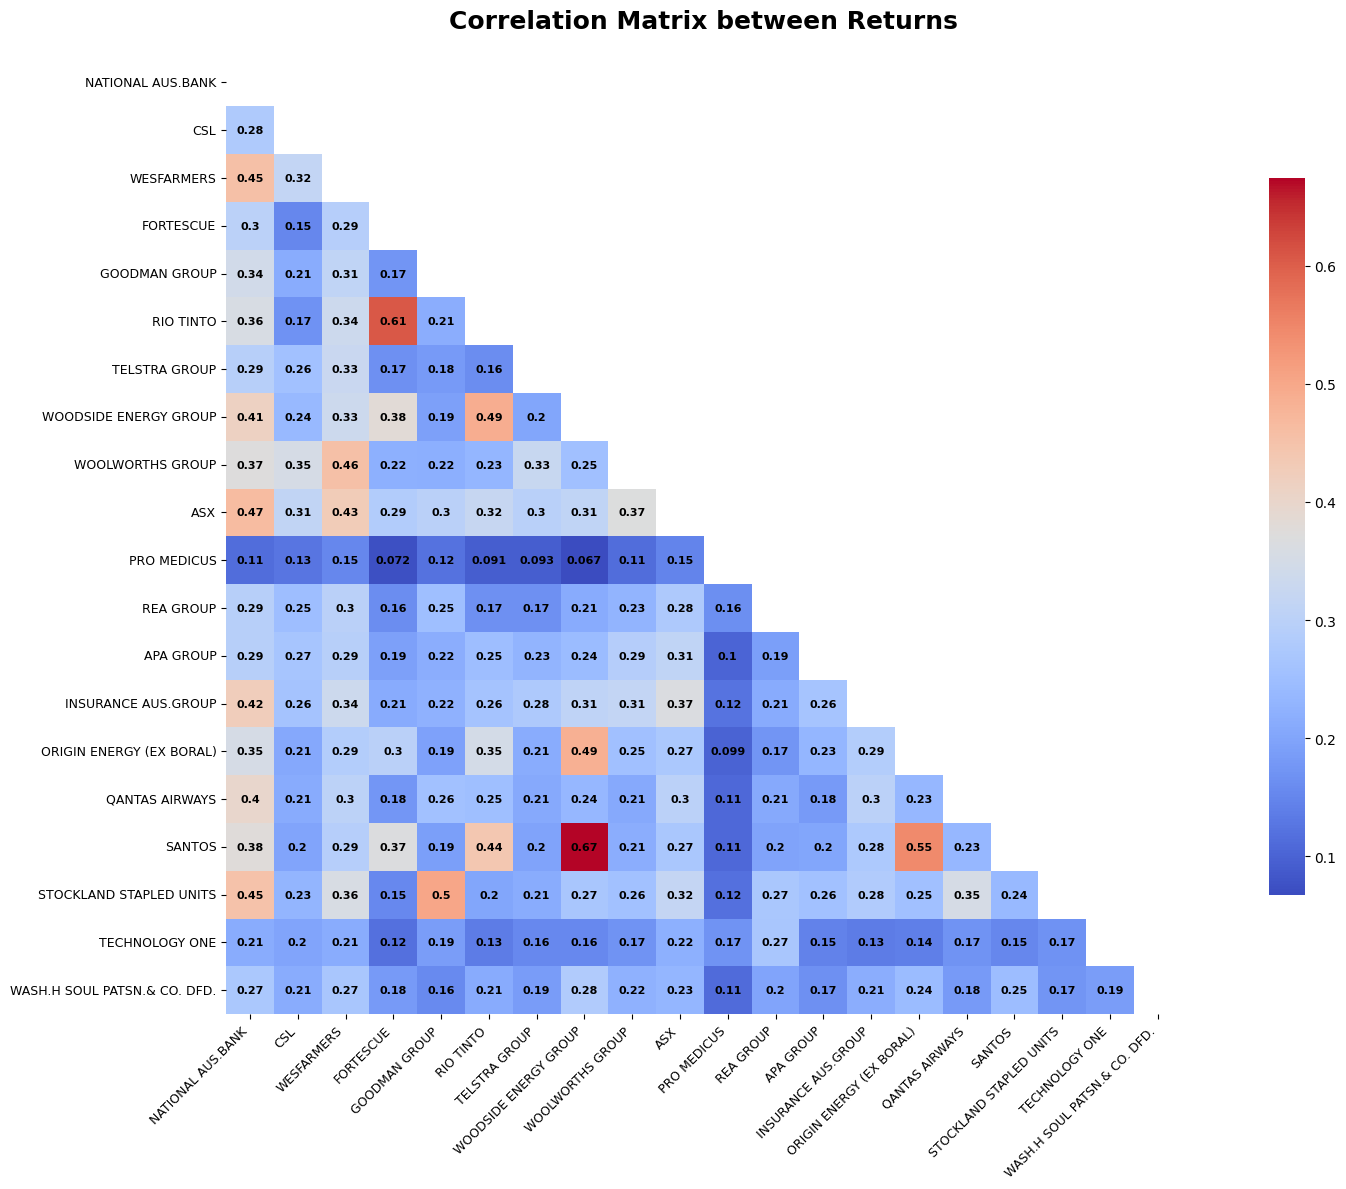

,mean,std,skew,kurtosis_excess,jarque_bera_p,ljungbox_p(10),n_extreme_3std
NATIONAL AUS.BANK,0.0288,1.5852,-0.4114,9.6432,0.0,0.0007,88
CSL,0.0559,1.5798,-0.4971,11.2308,0.0,0.0001,71
WESFARMERS,0.0426,1.4759,-0.4931,9.7347,0.0,0.0213,87
FORTESCUE,0.0918,3.3600,0.5581,11.7272,0.0,0.0350,68
GOODMAN GROUP,0.0347,2.5534,-0.7396,25.0658,0.0,0.0000,91
RIO TINTO,0.0359,2.1154,-1.7970,34.4719,0.0,0.0011,69
TELSTRA GROUP,0.0253,1.2412,-0.8480,8.3591,0.0,0.0100,77
WOODSIDE ENERGY GROUP,0.0133,1.8717,-0.4343,7.2448,0.0,0.0008,81
WOOLWORTHS GROUP,0.0263,1.2514,-0.7811,12.4112,0.0,0.0021,67
ASX,0.0298,1.4461,0.3630,13.0041,0.0,0.0000,85


In [ ]:
# Descriptive statistics dataframe
descriptive_stat_df = pd.DataFrame({
    "mean": returns_df.mean(),
    "std": returns_df.std(),
    "skew": returns_df.skew(),
    "kurtosis_excess": returns_df.kurtosis(),
    "jarque_bera_p": returns_df.apply(lambda x: stats.jarque_bera(x)[1]),
    "ljungbox_p(10)": returns_df.apply(lambda x: acorr_ljungbox(x, lags=[10], return_df=True)["lb_pvalue"].values[0]),
    "n_extreme_3std": returns_df.apply(lambda x: (np.abs(x) > 3 * x.std()).sum())
}).round(4)


HELPMEPLEASE.visual_descriptive_statistics(returns_df, plot=True, save=SAVE_PLOTS)